In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from Generator import Generator

In [2]:
generator = Generator('nutrients.csv') # filename with data

In [3]:
generator.generate(10000) # generates arg number of examples
generator.scale(0.1,1) # scales ingredients individually between min and max arg values
recipes = generator.recipes # recipes
quant = generator.quant # quantity of ingredients

In [4]:
embed_dim = 512
stack = 8
i1 = keras.layers.Input(recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for _ in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)

o1 = keras.layers.Dense(recipes.shape[1])(y1)
    
model = keras.Model(i1,o1)

2022-04-01 06:43:16.299500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-01 06:43:16.387465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-01 06:43:16.387828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-01 06:43:16.388936: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

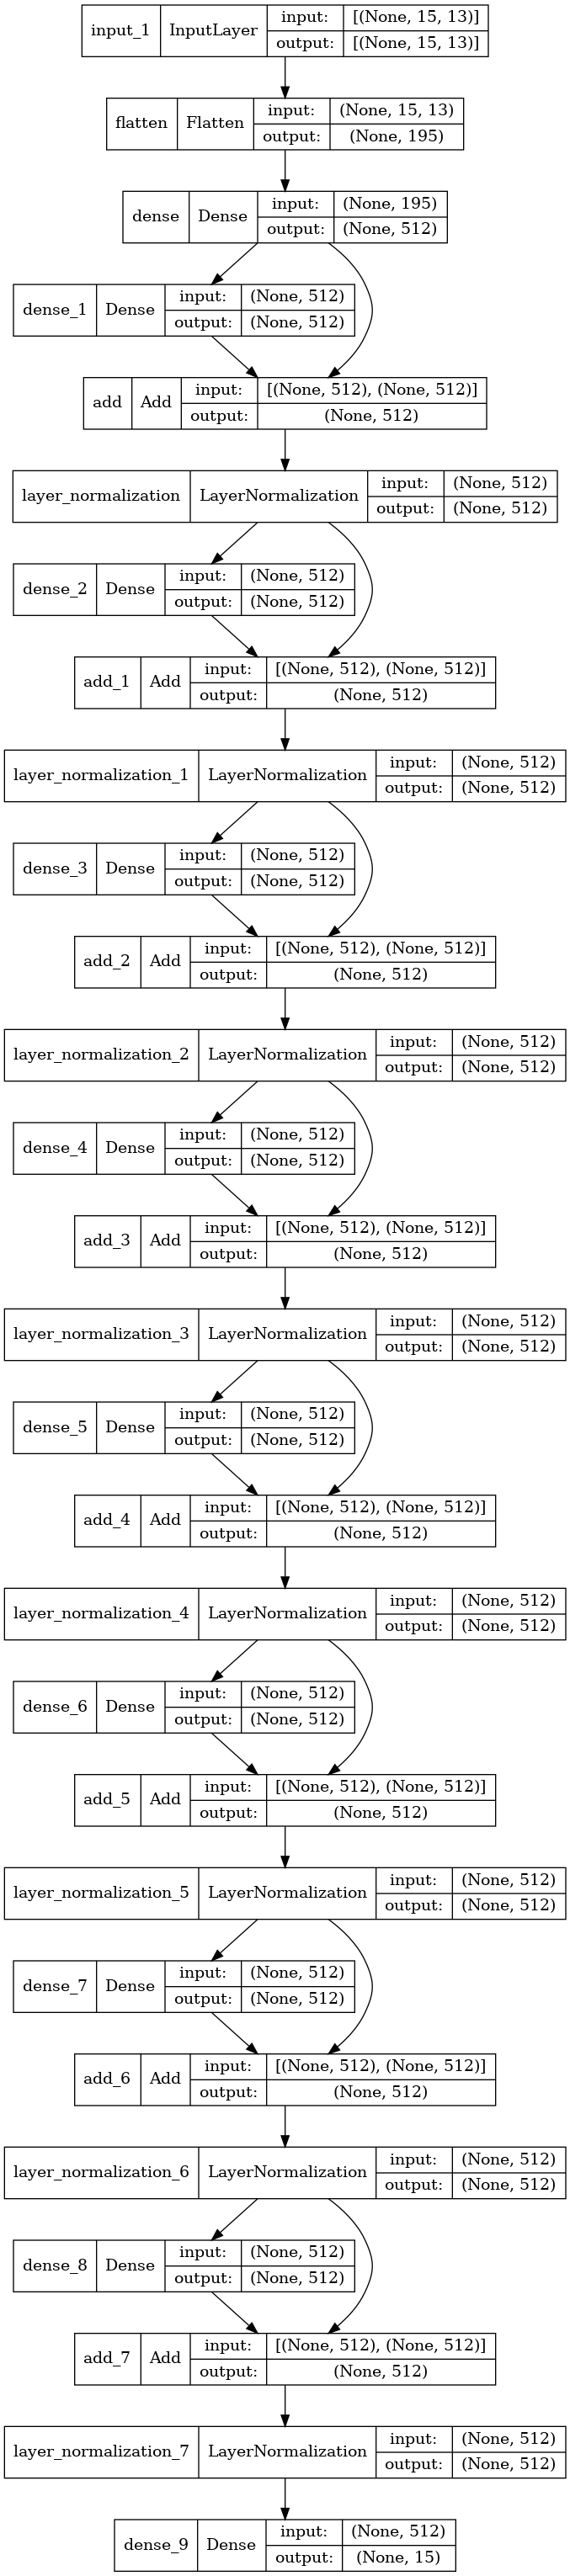

In [5]:
keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 13)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 195)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          100352      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                              

In [7]:
model.compile(optimizer=keras.optimizers.Nadam(),
            loss=keras.losses.MSE,
            metrics=keras.metrics.MeanSquaredError())

In [8]:
history = model.fit(
    recipes, quant, batch_size=128, epochs=100, validation_split = 0.2, verbose=2
)

Epoch 1/100


2022-04-01 06:43:53.718526: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-01 06:43:53.950699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


63/63 - 5s - loss: 0.4260 - mean_squared_error: 0.4260 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - 5s/epoch - 78ms/step
Epoch 2/100
63/63 - 1s - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - 695ms/epoch - 11ms/step
Epoch 3/100
63/63 - 1s - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.1035 - val_mean_squared_error: 0.1035 - 682ms/epoch - 11ms/step
Epoch 4/100
63/63 - 1s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - 653ms/epoch - 10ms/step
Epoch 5/100
63/63 - 1s - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 694ms/epoch - 11ms/step
Epoch 6/100
63/63 - 1s - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - 673ms/epoch - 11ms/step
Epoch 7/100
63/63 - 1s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - 676ms/epoch - 11ms/step


In [9]:
#prediction values
generator.generate(100) # generates arg number of examples
generator.scale(0.1,1) # scales ingredients individually between min and max arg values

In [10]:
recipes = generator.recipes
quant = generator.quant

In [11]:
score = model.evaluate(recipes, quant, verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 0.0137 - mean_squared_error: 0.0137


In [12]:
model.predict(recipes[0:1])

array([[0.6925941 , 0.22202712, 0.8464363 , 0.35492945, 0.8810417 ,
        0.07073887, 0.6540343 , 0.74514115, 0.39383435, 0.39124605,
        0.29883513, 0.15128954, 0.12736592, 0.6745456 , 0.41446957]],
      dtype=float32)

In [14]:
quant[0:1]

array([[0.78, 0.39, 0.98, 0.43, 0.99, 0.21, 0.7 , 0.88, 0.5 , 0.48, 0.4 ,
        0.18, 0.18, 0.73, 0.48]])